Для начала работы нужно осмотреть датасет и выйвить информации, которая нам не понадобиться. Это разнообразные даты и индексы.
Также можно было видеть плохую выборку в пункте ( площадь кухни ) для улучшения этого пункта уберём нули и обработаем выбросы ( методом медианы ) Данные операции помогут в дальнейшем

Немного информации:
IQR — это статистическая мера разброса данных, метод помогает определеить нормальный диапазон и обнаружить выбросы


In [28]:
import pandas as pd

df = pd.read_csv('input_data.csv', sep=';')

removed_columns = ['street_id', 'house_id', 'date', 'postal_code']
initial_shape = df.shape
df = df.drop(columns=removed_columns)

initial_zeros = (df['kitchen_area'] == 0).sum()
initial_negatives = (df['kitchen_area'] < 0).sum()
initial_nulls = df['kitchen_area'].isna().sum()

df['kitchen_area'] = pd.to_numeric(df['kitchen_area'], errors='coerce')
df['kitchen_area'] = df['kitchen_area'].where(df['kitchen_area'] > 0, pd.NA)

after_clean_nulls = df['kitchen_area'].isna().sum()
new_nulls = after_clean_nulls - initial_nulls

median_kitchen = df['kitchen_area'].median()
df['kitchen_area'] = df['kitchen_area'].fillna(median_kitchen).astype('float64')

Q1 = df['kitchen_area'].quantile(0.25)
Q3 = df['kitchen_area'].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df['kitchen_area'] < (Q1 - 1.5 * IQR)) | (df['kitchen_area'] > (Q3 + 1.5 * IQR))).sum()

final_stats = df['kitchen_area'].describe()

print(f"""
Обработка kitchen_area:
   - Найдено нулевых значений: {initial_zeros}
   - Найдено отрицательных значений: {initial_negatives}
   - Новых пропусков после очистки: {new_nulls}
   - Всего заполнено значений: {new_nulls}
   - Использованная медиана: {median_kitchen:.2f} м²
   - Обнаружено выбросов (метод IQR): {outliers}

""")

# Сохранение результата
df.to_csv('true_prices.csv', index=False)


Обработка kitchen_area:
   - Найдено нулевых значений: 2915928
   - Найдено отрицательных значений: 1092246
   - Новых пропусков после очистки: 4008174
   - Всего заполнено значений: 4008174
   - Использованная медиана: 9.20 м²
   - Обнаружено выбросов (метод IQR): 2095736




После обработки данных мы аолучаем +- чистый датасет, с которым можем продолжить дальнешую работу



Далее обработаем категориальные признаки, которые далее будем использовать в OneHotEncoder, в наглядные примеры, чтобы с ними было легче
работать человеку

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

df = pd.read_csv('cleaned_data.csv')

building_type_map = {
    0: 'Панельный',
    2: 'Кирпичный', 
    3: 'Монолитный',
    4: 'Деревянный',
    5: 'Блочный'
}

object_type_map = {
    0: 'Вторичка',
    2: 'Новостройка',
    3: 'Апартаменты'
}

rooms_map = {
    -1: 'Студия',
    1: '1-комн',
    2: '2-комн', 
    3: '3-комн'
}



Следующим шагом нашей работы будет полная обработка данных и поиск зависимостей, тоесть проведём EDA, также воспользуемся PCA, для уменьшения
избыточности. А для большей наглядности реализуем графики и проведём оценку, проделанной работе

Немного справочного материала:
Exploratory Data Analysis — это разведочный анализ данных
PCA — это алгоритм уменьшения размерности данных, который преобразует множество коррелированных признаков в меньшее число новых переменных

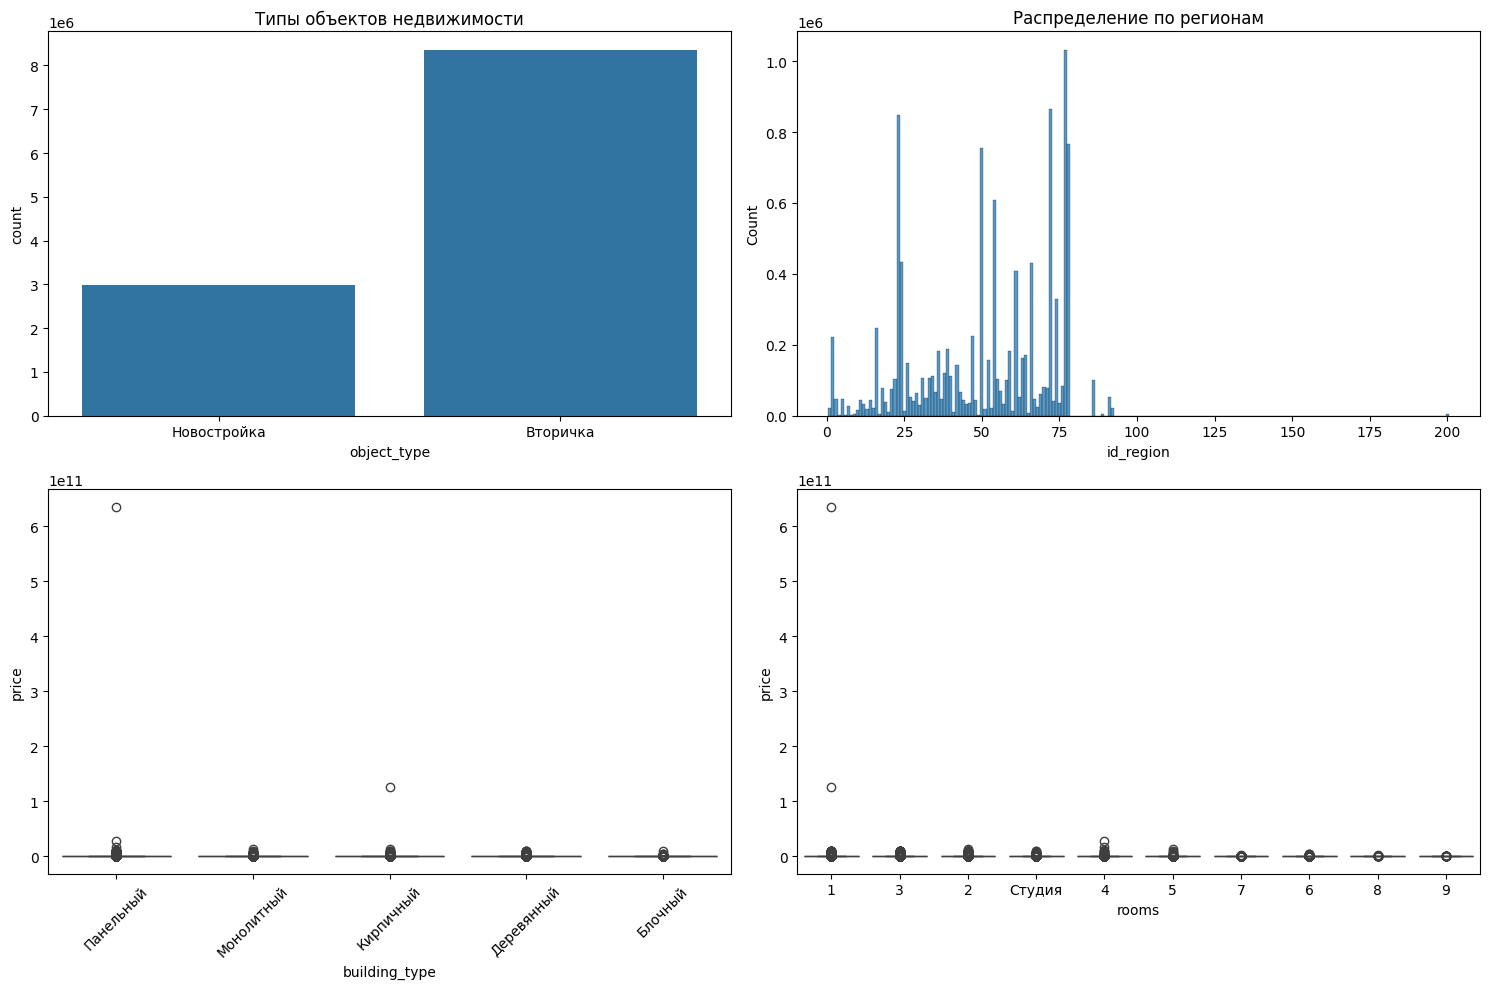

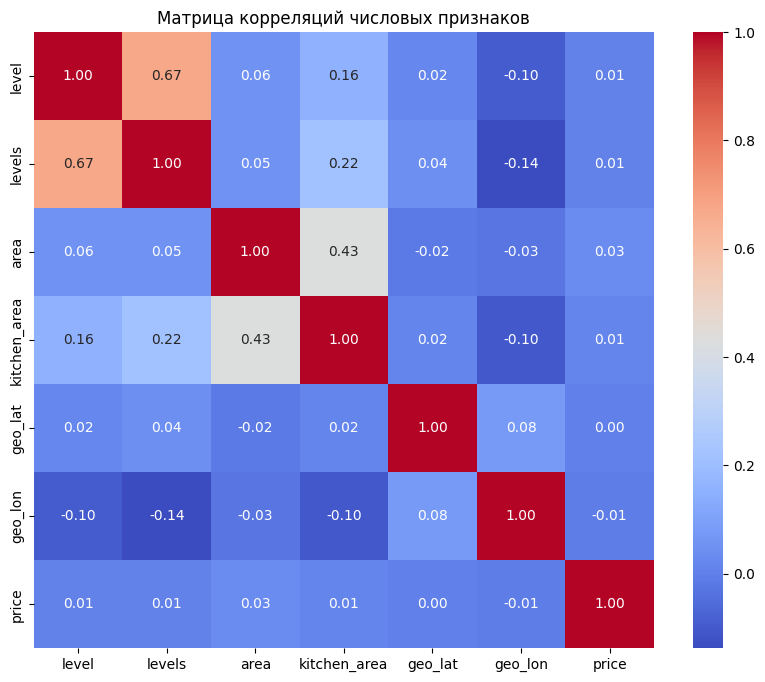

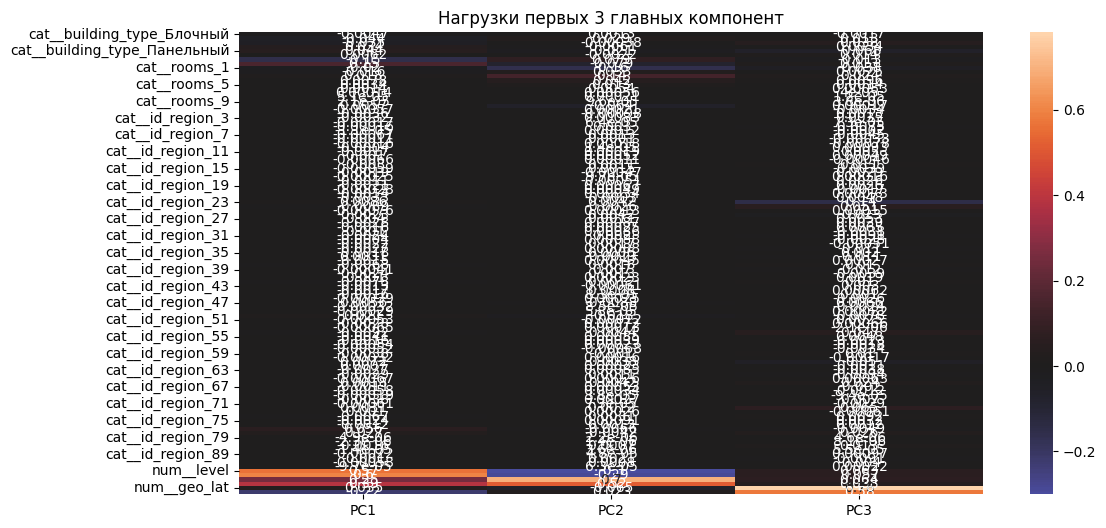


Результаты анализа:
1. Категориальные признаки преобразованы с учетом доменного знания:
   - Типы зданий: ['Панельный', 'Кирпичный', 'Монолитный', 'Деревянный', 'Блочный']
   - Типы объектов: ['Вторичка', 'Новостройка', 'Апартаменты']
   - Комнаты: ['Студия', '1-комн', '2-комн', '3-комн']
   
2. PCA выявил 25 ключевых компонент, сохраняющих 95% дисперсии




In [31]:
df['building_type'] = df['building_type'].map(building_type_map)
df['object_type'] = df['object_type'].map(object_type_map)
df['rooms'] = df['rooms'].replace({-1: 'Студия'}).astype(str)

df['id_region'] = df['id_region'].astype('category')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Распределение по типам недвижимости
sns.countplot(x='object_type', data=df, ax=axes[0,0])
axes[0,0].set_title('Типы объектов недвижимости')

# Распределение по регионам
sns.histplot(df['id_region'], bins=50, ax=axes[0,1])
axes[0,1].set_title('Распределение по регионам')

# Зависимость цены от типа здания
sns.boxplot(x='building_type', y='price', data=df, ax=axes[1,0])
axes[1,0].tick_params(axis='x', rotation=45)

# Зависимость цены от количества комнат
sns.boxplot(x='rooms', y='price', data=df, ax=axes[1,1])

plt.tight_layout()
plt.show()

categorical_features = ['building_type', 'object_type', 'rooms', 'id_region']
numeric_features = ['level', 'levels', 'area', 'kitchen_area', 'geo_lat', 'geo_lon']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ])

X = preprocessor.fit_transform(df)
y = df['price']

corr_matrix = df[numeric_features + ['price']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций числовых признаков')
plt.show()

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X.toarray())

loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=preprocessor.get_feature_names_out()
)

plt.figure(figsize=(12,6))
sns.heatmap(loadings.iloc[:,:3], annot=True, cmap='icefire', center=0)
plt.title('Нагрузки первых 3 главных компонент')
plt.show()

print(f"""
Результаты анализа:
1. Категориальные признаки преобразованы с учетом доменного знания:
   - Типы зданий: {list(building_type_map.values())}
   - Типы объектов: {list(object_type_map.values())}
   - Комнаты: {list(rooms_map.values())}
   
2. PCA выявил {pca.n_components_} ключевых компонент, сохраняющих 95% дисперсии

""")

Если смотреть на получившиеся графики, можно увидеть, что самая большая зависимость наблюдается от площади и кол-во комнат, это довольно 
логично, это отображает реальную жижнь. Но также видно, что дригие признаки влияют не так сильно, возможно, нужно их рассматривать под другим
углов, например, узнать местоположения объекта, или найти ещё больше информации

Следующая задача это обучить и реализовать ML модель, также нужно выполнить последовательное и параллельное обучение

Для выполнение этой задачи хотелось бы разобраться в чём заключается разница:
- Смысл последовательного обучения состоит в построение моделей одна за другой, где каждая последующая модель учится на ошибках предыдущей или улучшает её предсказания
- Смысл параллельного обучения состоит в независимом обучении нескольких моделей с последующим объединением их результатов

Также нам понадобяться следующии знания;
- Lasso (L1-регуляризация) выполняет автоматический отбор признаков, обнуляя неважные коэффициенты, удобно когда признаков много, но важность у них маленькая(
- RandomForest большое кол-во деревьев, которые работаю и обучаются параллельно, метод полезен принелинейных зависимостях и категориальных признаках 

Наконец приступим в обучению

In [58]:
import time
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from joblib import Parallel, delayed

df = pd.read_csv('cleaned_data_10.csv')

X = df.drop(columns=['price'])
y = df['price']
enknown = y.notnull()
X_train_full = X[enknown]
y_train_full = y[enknown]
X_new = X[~enknown].copy()
common_indices = X_new.index.intersection(df_true.index)  # Найти пересечение индексов
y_true_new = df_true.loc[common_indices, 'price']        # Взять только существующие
X_new = X_new.loc[common_indices]                        # Обновить X_new
y_true_new = df_true.loc[X_new.index, 'price']

i = int(0.8 * len(X_train_full))
X_tr, X_te = X_train_full.iloc[:i], X_train_full.iloc[i:]
y_tr, y_te = y_train_full.iloc[:i], y_train_full.iloc[i:]

cat_cols = ['building_type', 'object_type', 'rooms', 'id_region']
num_cols = [c for c in X_tr.columns if c not in cat_cols]

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()

X_tr_cat = ohe.fit_transform(X_tr[cat_cols])
X_tr_num = scaler.fit_transform(X_tr[num_cols])
X_tr_proc = np.hstack([X_tr_num, X_tr_cat])

X_te_cat = ohe.transform(X_te[cat_cols])
X_te_num = scaler.transform(X_te[num_cols])
X_te_proc = np.hstack([X_te_num, X_te_cat])

X_new_cat = ohe.transform(X_new[cat_cols])
X_new_num = scaler.transform(X_new[num_cols])
X_new_proc = np.hstack([X_new_num, X_new_cat])

pca = PCA(n_components=0.95, random_state=42)
X_tr_pca = pca.fit_transform(X_tr_proc)
X_te_pca = pca.transform(X_te_proc)
X_new_pca = pca.transform(X_new_proc)

Небольшая сводка:
- Значение, которое мы будем присваивать в random_state взято из филма "Автостопом по галактике" поэтому 42 :)
- Параметр n_jobs отвечает за кол-во ядер, используемых в обучении ( 1 - это одно ядро, -1 - это все ядра, также можно использовать любое нужное вам количество )

In [59]:
models = {
    'lasso': Lasso(alpha=1.0, random_state=42, max_iter=10000000),
    'rf': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1)
}
models_par = {
    'lasso': Lasso(alpha=1.0, random_state=42, max_iter=10000000),
    'rf': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

Для оценки воспользуемся следующими метриками:
MSE - среднеквадратичная ошибка
MAE - средняя абсолютная ошибка
MAPE - средняя абсолютная процентная ошибка
Заодно посчитаем время обучения, эта информация будет храниться в переменной time

In [60]:
# Последовательное обучение
def eval_models(model_dict, X_train, X_test, y_train, y_test):
    results = []
    for name, model in model_dict.items():
        t0 = time.time()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        results.append({
            'model': name,
            'MSE': mean_squared_error(y_test, preds),
            'MAE': mean_absolute_error(y_test, preds),
            'MAPE': mean_absolute_percentage_error(y_test, preds)*100,
            'time': time.time() - t0
        })
    return results

results_seq = eval_models(models, X_tr_pca, X_te_pca, y_tr, y_te)

# Параллельное обучение
start = time.time()
results_par = Parallel(n_jobs=-1)(
    delayed(lambda nm, mdl: {
        **{'model': nm},
        **dict(
            MSE=mean_squared_error(y_te, mdl.fit(X_tr_pca, y_tr).predict(X_te_pca)),
            MAE=mean_absolute_error(y_te, mdl.predict(X_te_pca)),
            MAPE=mean_absolute_percentage_error(y_te, mdl.predict(X_te_pca))*100,
            time=0  
        )
    })(name, model)
    for name, model in models_par.items()
)
end = time.time()

for res in results_par:
    res['time'] = end - start

df_seq = pd.DataFrame(results_seq).set_index('model')
df_par = pd.DataFrame(results_par).set_index('model')
comparison = df_seq.join(df_par, lsuffix='_seq', rsuffix='_par')
print("Сравнение последовательного и параллельного подходов (валидация):")
print(comparison)

Сравнение последовательного и параллельного подходов (валидация):
            MSE_seq       MAE_seq   MAPE_seq   time_seq       MSE_par  \
model                                                                   
lasso  5.027736e+13  3.329302e+06  95.004618   0.067524  5.027736e+13   
rf     3.768339e+13  1.668664e+06  33.874126  30.395788  3.768339e+13   

            MAE_par   MAPE_par   time_par  
model                                      
lasso  3.329302e+06  95.004618  16.075641  
rf     1.668664e+06  33.874126  16.075641  


Выоды и сравнения:
Как уже было сказанно ранне, метрика MAPE даёт нам процент ошибок, тоесть более наглядна, поэтому в выводе будем отталкиваться от неё.
Мы можем увидеть, что метод RandomForest гораздо лучше прогназирует результат, ошибки в 34% против 95%, это огромная разница, но нельзя говорить о какой-то удачи, так как 30% это не самый хороший результат, желательно как-то поработать над данными, это я уже описывал выше.

Также мы можем увидеть, что метод параллельного обучения в случае RandomForest гораздо быстрее, чем последовательный. Сравнивать метод lasso в этих двух обучениях нет смысла, так так его нельзя обучать параллельного

Ещё хочеться отметить следующуую тенденцию. При каждом новом параллельном обучении на одинаковых данных время ускоряеться, это конечно логично, так как система оптимизирует процессы и кеширует данные в памяти, но хотелось это подметить:
1 запуск - 11.7 сек
2 запуск - 2.6 сек
3 запуск - 2.3 сек
4 запуск - 2 сек
5 запуск - 1.8 сек
Эти данные для меньшего датасета (1к позиций)

Теперь разберёмся с параметром n_jobs
Для наглядности реализуем графики

Результаты обучения:
    n_jobs       time           MSE           MAE       MAPE
0       1  27.220212  3.768339e+13  1.668664e+06  33.874126
1       2  15.323805  3.768339e+13  1.668664e+06  33.874126
2       4  12.056279  3.768339e+13  1.668664e+06  33.874126
3       8  13.220451  3.768339e+13  1.668664e+06  33.874126


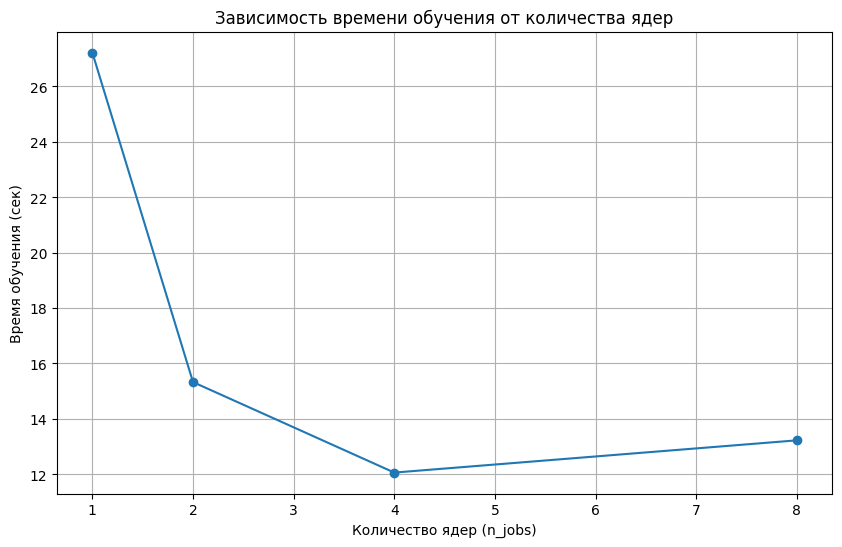

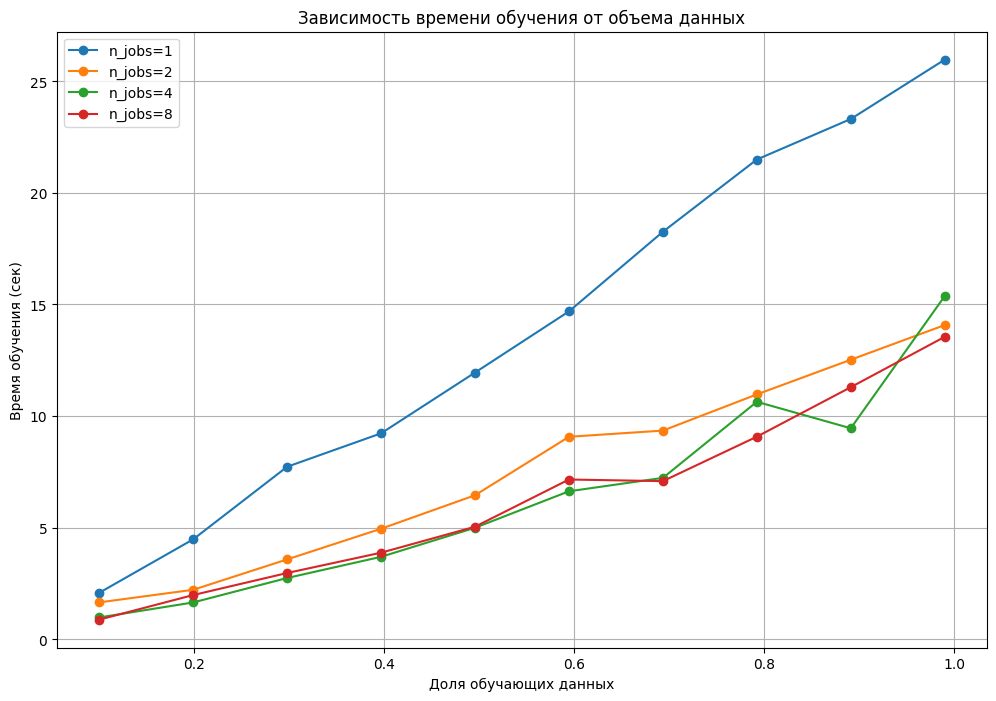

In [61]:
# Время vs n_jobs
n_jobs_values = [1, 2, 4, 8] 
rf_models = []
results = []

for n_jobs in n_jobs_values:
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=n_jobs)
    start = time.time()
    model.fit(X_tr_pca, y_tr)
    train_time = time.time() - start
    preds = model.predict(X_te_pca)
    results.append({
        'n_jobs': n_jobs,
        'time': train_time,
        'MSE': mean_squared_error(y_te, preds),
        'MAE': mean_absolute_error(y_te, preds),
        'MAPE': mean_absolute_percentage_error(y_te, preds)*100
    })
    rf_models.append(model)

df_results = pd.DataFrame(results)
print("Результаты:\n", df_results)

# График времени vs n_jobs
plt.figure(figsize=(10,6))
plt.plot(df_results['n_jobs'], df_results['time'], marker='o')
plt.xlabel('Количество ядер (n_jobs)')
plt.ylabel('Время обучения (сек)')
plt.title('Зависимость времени обучения от количества ядер')
plt.grid(True)

# Время vs объем данных
data_sizes = np.linspace(0.1, 0.99, 10)
results_data = []

for size in data_sizes:
    subset_size = float(size)
    X_sub, _, y_sub, _ = train_test_split(
        X_tr_pca, 
        y_tr, 
        train_size=subset_size, 
        random_state=42
    )
    
    for n_jobs in n_jobs_values:
        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=n_jobs)
        start = time.time()
        model.fit(X_sub, y_sub)
        results_data.append({
            'data_size': subset_size,
            'n_jobs': n_jobs,
            'time': time.time() - start
        })

df_data = pd.DataFrame(results_data)

# Графики времени vs объем данных
plt.figure(figsize=(12,8))
for n_jobs in n_jobs_values:
    subset = df_data[df_data['n_jobs'] == n_jobs]
    plt.plot(subset['data_size'], subset['time'], marker='o', label=f'n_jobs={n_jobs}')
plt.xlabel('Доля обучающих данных')
plt.ylabel('Время обучения (сек)')
plt.title('Зависимость времени обучения от объема данных')
plt.legend()
plt.grid(True)

Проанализировав графики, можно придти к выводу, что они давольно логичны, с повышением производительности, тоесть повышением кол-во ядер скорость обучения обучается. А также время обучение увеличивается с количеством данных, этот праметр также очень схож с реальной жизнью.

Хотелось бы добавить, что обучение проводилось на MacBook Air, в процессоре которого 4 ядра, поэтому на графике зафисимости времени от кол-во яядер, после отметки в 4 ядра, график не меняется 